In [1]:
from src.Library import *
from src.preprocessing.Data_Preparation import *
from src.preprocessing.Data_Preparation2 import *
import folium
import pickle
import os
from tqdm import tqdm
import json
from IPython.display import Markdown, display


def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
class drives:
    def __init__(self, car_id, agg_df, dict_sum, dict_cor, dict_drives, all_drives,
                 df, neigh_dict, groups_ts, splitted_ts_groups, scaling_parameters,
                 dict_length, new_dict, groups_splitted_normlized_ts, df_spectral):
        self.car_id = car_id #id of the car 
        self.agg_df = agg_df #aggregated df for pattern detection
        self.dict_sum = dict_sum #shows how many drives for each group 
        self.dict_cor = dict_cor #show the end coordinate for each group 
        self.dict_drives = dict_drives #saves the drives as ts for each group
        self.all_drives = all_drives #list of all the drives as ts 
        self.df = df #metadata of the drives
        self.neigh_dict = neigh_dict #map each group to its destination neighberhood
        self.groups_ts = groups_ts #dict that contains ts of each group 
        self.splitted_ts_groups = splitted_ts_groups #dict that contains segmented ts of each group 
        self.scaling_parameters = scaling_parameters #dict that helps standetize the ts 
        self.dict_length = dict_length #ts sorted by their lengths
        self.new_dict = new_dict
        self.groups_splitted_normlized_ts = groups_splitted_normlized_ts #ts divided into groups after segmented and standetize
        self.df_spectral = df_spectral #metrix that shows the probability for each group to be the same driver


In [3]:

def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=5)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1','PC2', 'PC3','PC4','PC5']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]

        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].mean().values,
            'std': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].std().values
        }

    return group_stats

In [20]:
def transform_rocket(dict_length ,label =1 ):    
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
   
        if key<9:
            continue
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels

        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(100))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=15)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC10', 'PC11', 'PC12','PC13','PC14','PC15'])

    return df_pca

In [4]:
import pandas as pd
import numpy as np


def compute_cluster(neighbors_dict, dict_length, rand=100):
    """
    Computes clusters using MiniRocket transformation, PCA, and Spectral Clustering.
    Returns the labels for Spectral Clustering.
    """
    spectral_matrix = np.zeros((len(neighbors_dict), len(neighbors_dict)))
    
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group']-1)
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        
        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(rand))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
    df_pca['group'] = t_labels

    # Calculate statistics for the largest cluster
    group_stats = calculate_stats_for_largest_cluster(df_pca)

    # Extract means for clustering
    X_means = np.array([stats['mean'] for stats in group_stats.values()])
    group_labels = list(group_stats.keys())

    def evaluate_spectral_clustering(X):
    
        silhouette_scores_spectral = []

#         for k in range(2, len(neigh_dict)-1):
        for k in range(2, len(neigh_dict)):
            # Spectral Clustering
            spectral = SpectralClustering(n_clusters=k, random_state=42)
            spectral_labels = spectral.fit_predict(X)

            # Check if there is more than one unique label
            if len(set(spectral_labels)) > 1:
                # Calculate silhouette score only if there is more than one unique cluster
                silhouette_scores_spectral.append(silhouette_score(X, spectral_labels))
            else:
                # Append a placeholder score (e.g., -1) if only one cluster is found
                silhouette_scores_spectral.append(-1)

        return silhouette_scores_spectral
    # Evaluate silhouette scores for Spectral Clustering
    silhouette_scores_spectral = evaluate_spectral_clustering(X_means)

    # Determine the best k for Spectral Clustering based on silhouette scores
    best_k_spectral = np.argmax(silhouette_scores_spectral) + 2

    # Apply Spectral Clustering with the best k
    spectral_labels = SpectralClustering(n_clusters=best_k_spectral, random_state=42).fit_predict(X_means)

    return spectral_labels

In [5]:
def highlight_cells(val):
    color = 'background-color: lightgreen' if val >= 0.9 else ''
    return color

In [ ]:
vehicle_ids=[485783, 463298, 397821, 393069, 385024, 488730, 379252, 467650, 408049, 454751, 473237, 467836, 430135, 442134, 472248, 446778, 408764, 401474, 460624, 430111, 382995, 401325, 401483, 410611, 416266, 472667, 442194, 427121, 485760, 392345]

In [5]:
mitzubishi_ids =[460631,379771, 382464, 386627, 387960, 424306, 444040, 448174, 450593, 450601, 450603, 454751, 472233, 472239, 473235, 486347, 493989, 493992]

In [3]:
for v in mitzubishi_ids:
    Prepare_metadata_by_vehicle_number(vehicle_ids=v)

NameError: name 'mitzubishi_ids' is not defined

In [ ]:
for v in vehicle_ids:
    Prepare_metadata_by_vehicle_number(vehicle_ids=v)

In [52]:
matrix_dict = {}
for v in tqdm(mitzubishi_ids):
    if os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/drives_instances/{v}.pkl"):
        continue
    try:
        agg_df = aggregating_car_data_for_pattern(v)
        dict_sum, dict_cor, dict_drives = dict_creation_driving_groups(agg_df,v)
        all_drives = loading_ts_drives(v)
        df = concated_data_with_feat(v)
        dict_sum, dict_cor, dict_drives, neigh_dict = fixing_and_sorting_dicts(dict_sum, dict_cor, dict_drives)
        groups_ts = create_dict_groups2ts(dict_drives, all_drives)
        splitted_ts_groups = create_feat_(groups_ts)
        scaling_parameters = scaling(splitted_ts_groups)
        dict_length = {}
        for group in groups_ts:
            for se in groups_ts[group]:
                curr_len = len(se)
                se['group'] = group
                dict_length[curr_len] = dict_length.get(curr_len,[])
                dict_length[curr_len].append(se)


        new_dict = {key: scaling_parameters[key]  for key in scaling_parameters if len(scaling_parameters[key])>30}
        groups_splitted_normlized_ts = {}
        for key in new_dict:
            lst = normalize_time_series(new_dict[key])
            for series in lst:
                group_num = int(series.iloc[0][['group']])
                groups_splitted_normlized_ts[group_num] = groups_splitted_normlized_ts.get(group_num,[])
                groups_splitted_normlized_ts[group_num].append(series)

        dict_length = {}
        for group in groups_splitted_normlized_ts:
            for series in groups_splitted_normlized_ts[group]:
                curr_len = len(series)
                if curr_len>=9:
                    dict_length[curr_len] = dict_length.get(curr_len,[])
                    dict_length[curr_len].append(series)
        num_runs = 150
        random_states = np.random.randint(0, 10000, size=num_runs)
        spectral_matrix = np.zeros((len(neigh_dict), len(neigh_dict)))

        for rand in random_states:
            spectral_labels = compute_cluster(neigh_dict, dict_length, rand)

            # Dictionary to count occurrences of clustering
            s_cluster_dict = {}

            # Count occurrences of clustering
            for i, group in enumerate(neigh_dict.keys()):
                s_cluster_dict[group] = spectral_labels[i]

            # Update matrix based on clustering results
            for group in s_cluster_dict:
                for j in s_cluster_dict:
                    if s_cluster_dict[group] == s_cluster_dict[j]:
                        spectral_matrix[int(group - 1), int(j - 1)] += 1

        rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
        df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                                 index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                                 columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])

        drive_instance = drives(
                                car_id=v,
                                agg_df=agg_df,
                                dict_sum=dict_sum,
                                dict_cor=dict_cor,
                                dict_drives=dict_drives,
                                all_drives=all_drives,
                                df=df,
                                neigh_dict=neigh_dict,
                                groups_ts=groups_ts,
                                splitted_ts_groups=splitted_ts_groups,
                                scaling_parameters=scaling_parameters,
                                dict_length=dict_length,
                                new_dict=new_dict,
                                groups_splitted_normlized_ts=groups_splitted_normlized_ts,
                                df_spectral=df_spectral
                                )


        # Save the instance
        with open(f"/bigdata/users-home/dor/transpotation research/agg_data/drives_instances/{v}.pkl", "wb") as file:
            pickle.dump(drive_instance, file)


        df_spectral = df_spectral.style.applymap(highlight_cells)
        matrix_dict[v] = df_spectral
        df_spectral
    except:
        print("failed to classify",v)
        continue

  0%|                                                                                                         | 0/18 [00:00<?, ?it/s]

Neighborhood: Hadar Yosef 1
Neighborhood: Tel Aviv University 2
Neighborhood: Naot Uzi 3
Neighborhood: Neot Afeka A 5
Neighborhood: Rom 2000 6
Neighborhood: HaOgen 4
Neighborhood: Herzliya B 7


  6%|█████▏                                                                                        | 1/18 [16:11<4:35:22, 971.89s/it]

Neighborhood: Nahalat Yizhaq 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [17:26<00:00, 58.14s/it]

failed to classify 486347


In [6]:
lst_car=[]
for v in tqdm(mitzubishi_ids):
    
    file_path = f"/bigdata/users-home/dor/transpotation research/agg_data/drives_instances/{v}.pkl"

    if os.path.exists(file_path):
        with open(file_path, "rb") as file:
            drive_instance = pickle.load(file)
        print(f"Loaded object for car_id: {drive_instance.car_id}")
        lst_car.append(drive_instance)
    else:
        print(f"File not found: {file_path}")


  6%|█████▍                                                                                           | 1/18 [00:03<00:55,  3.29s/it]

Loaded object for car_id: 460631


 11%|██████████▊                                                                                      | 2/18 [00:05<00:38,  2.40s/it]

Loaded object for car_id: 379771


 17%|████████████████▏                                                                                | 3/18 [00:09<00:46,  3.12s/it]

Loaded object for car_id: 382464


 22%|█████████████████████▌                                                                           | 4/18 [00:12<00:47,  3.36s/it]

Loaded object for car_id: 386627


 28%|██████████████████████████▉                                                                      | 5/18 [00:18<00:54,  4.18s/it]

Loaded object for car_id: 387960


 33%|████████████████████████████████▎                                                                | 6/18 [00:25<01:00,  5.01s/it]

Loaded object for car_id: 424306


 39%|█████████████████████████████████████▋                                                           | 7/18 [00:29<00:52,  4.80s/it]

Loaded object for car_id: 444040


 44%|███████████████████████████████████████████                                                      | 8/18 [00:34<00:49,  5.00s/it]

Loaded object for car_id: 448174


 50%|████████████████████████████████████████████████▌                                                | 9/18 [00:40<00:47,  5.33s/it]

Loaded object for car_id: 450593


 56%|█████████████████████████████████████████████████████▎                                          | 10/18 [00:42<00:34,  4.31s/it]

Loaded object for car_id: 450601


 61%|██████████████████████████████████████████████████████████▋                                     | 11/18 [00:48<00:33,  4.83s/it]

Loaded object for car_id: 450603


 67%|████████████████████████████████████████████████████████████████                                | 12/18 [00:52<00:25,  4.32s/it]

Loaded object for car_id: 454751


 72%|█████████████████████████████████████████████████████████████████████▎                          | 13/18 [00:59<00:26,  5.33s/it]

Loaded object for car_id: 472233


 78%|██████████████████████████████████████████████████████████████████████████▋                     | 14/18 [01:07<00:23,  5.93s/it]

Loaded object for car_id: 472239


 83%|████████████████████████████████████████████████████████████████████████████████                | 15/18 [01:10<00:15,  5.04s/it]

Loaded object for car_id: 473235
File not found: /bigdata/users-home/dor/transpotation research/agg_data/drives_instances/486347.pkl


 94%|██████████████████████████████████████████████████████████████████████████████████████████▋     | 17/18 [01:19<00:04,  4.93s/it]

Loaded object for car_id: 493989


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [01:21<00:00,  4.55s/it]

Loaded object for car_id: 493992


In [7]:
tresh = 0.912
for obj in lst_car:
    obj.clusters = {}
    df_spectral = obj.df_spectral.data if hasattr(obj.df_spectral, 'data') else obj.df_spectral  # Handle styled DataFrame
    visited = set()
    try:
        # Iterate over groups (index) to find clusters
        for group in df_spectral.index:
            if group in visited:
                continue  # Skip already clustered groups

            # Find all groups with similarity >= tresh
            high_sim_groups = [g for g in df_spectral.columns if df_spectral.at[group, g] >= tresh and g not in visited]

            # Check if the group has no high similarity connections
            if len(high_sim_groups) == 1:  # The group itself
                # Check borderline similarities
                borderline_groups = [g for g in df_spectral.columns if (1 - tresh) < df_spectral.at[group, g] < tresh]

                if len(borderline_groups) > 0:
                    # Ignore this group (as it has borderline connections)
                    continue
                else:
                    # Form a single cluster for this group
                    cluster_id = len(obj.clusters) + 1
                    obj.clusters[cluster_id] = [group]
                    visited.add(group)
            elif len(high_sim_groups) > 1:
                # Validate all groups in high_sim_groups are compatible
                valid_cluster = True
                for g1 in high_sim_groups:
                    for g2 in high_sim_groups:
                        if g1 != g2 and df_spectral.at[g1, g2] < tresh:
                            valid_cluster = False
                            break
                    if not valid_cluster:
                        break

                if valid_cluster:
                    # Form a cluster for groups with high similarity
                    cluster_id = len(obj.clusters) + 1
                    obj.clusters[cluster_id] = high_sim_groups
                    visited.update(high_sim_groups)
                else:
                    # Ignore the group as it doesn't fit a valid cluster
                    visited.add(group)

        # Print or debug the clusters for this obj
        print(f"Clusters for car {obj.car_id}: {obj.clusters}")
    except Exception as e:
        print(f"Error processing car {obj.car_id}: {e}")
        continue


Clusters for car 460631: {1: ['Hadar Yosef', 'Neot Afeka A', 'Rom 2000', 'Herzliya B'], 2: ['Tel Aviv University', 'HaOgen']}
Clusters for car 379771: {1: ['Citi', '2004', 'Herzliya B'], 2: ['Shikun Ovdim', 'Kiryat Etgarim']}
Clusters for car 382464: {1: ['Neve Zeev', 'Ramot B', 'Ramot'], 2: ['Gimel', 'City Center']}
Clusters for car 386627: {1: ['Ramot Menachem', 'Sgula'], 2: ['Ramat Siv Industrial Zone', 'Magdiel']}
Clusters for car 387960: {1: ['Shikun Vatikim'], 2: ['German Colony', 'HaParpar'], 3: ['Givat HaRakafot', 'Kiriat HaMemshalah Rabin', 'Sderot Weizmann']}
Error processing car 424306: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Clusters for car 444040: {1: ['Em Hamoshavot hadasha', 'Circle Road', 'Kiryat Aryeh Industrial Zone'], 2: ['Mahane Yehuda', 'Yaaf', 'Sgula']}
Clusters for car 448174: {1: ['Ramat Siv Industrial Zone', 'Ramot Menachem'], 2: ['Glilot']}
Clusters for car 450593: {1: ['Ramot Alef', 'Ramot'], 2: ['Ramot 

In [8]:

for obj in lst_car:
    obj.drivers = {}
    for group in obj.neigh_dict:
        for cluster in obj.clusters:
            if obj.neigh_dict[group] in obj.clusters[cluster]:
                obj.drivers[cluster] = obj.drivers.get(cluster,[])
                obj.drivers[cluster] += obj.groups_splitted_normlized_ts[group]

In [9]:
i = 0
all_mitsubishi_drivers = {}
for obj in lst_car:
    for driver in obj.drivers:
        i+=1
        all_mitsubishi_drivers[i] = obj.drivers[driver]


In [14]:
dict_length = {}
for group in all_mitsubishi_drivers:
    for series in all_mitsubishi_drivers[group]:
        series['group'] = group
        curr_len = len(series)
        if curr_len>=9:
            dict_length[curr_len] = dict_length.get(curr_len,[])
            dict_length[curr_len].append(series)

In [15]:
all_mitsubishi_drivers.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [16]:
num_runs = 150
numbers = list(all_mitsubishi_drivers.keys())
neigh_dict = {num: num for num in numbers}

random_states = np.random.randint(0, 10000, size=num_runs)
spectral_matrix = np.zeros((len(neigh_dict), len(neigh_dict)))

for rand in random_states:
    spectral_labels = compute_cluster(neigh_dict, dict_length, rand)

    # Dictionary to count occurrences of clustering
    s_cluster_dict = {}

    # Count occurrences of clustering
    for i, group in enumerate(neigh_dict.keys()):
        s_cluster_dict[group] = spectral_labels[i]

    # Update matrix based on clustering results
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1

rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                         columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])

In [17]:
tresh = 0.9
clusters = {}
visited = set()

# Iterate over groups (index) to find clusters
for group in df_spectral.index:
    if group in visited:
        continue  # Skip already clustered groups

    # Find all groups with similarity >= tresh
    high_sim_groups = [g for g in df_spectral.columns if df_spectral.at[group, g] >= tresh and g not in visited]

    if high_sim_groups:
        # Form a cluster for all groups with high similarity
        cluster_id = len(clusters) + 1
        clusters[cluster_id] = high_sim_groups
        visited.update(high_sim_groups)

# Print the resulting clusters
print("Clusters:", clusters)

Clusters: {1: [1, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 20, 21, 23, 24, 26, 27, 28, 29, 31], 2: [2, 4, 10, 13, 19, 22, 25, 30, 32], 3: [3], 4: [5], 5: [17]}


In [18]:
driver1_train = all_mitsubishi_drivers[6]+all_mitsubishi_drivers[7]+all_mitsubishi_drivers[31]+all_mitsubishi_drivers[20]+all_mitsubishi_drivers[18]
driver2_train = all_mitsubishi_drivers[4]+all_mitsubishi_drivers[10]+all_mitsubishi_drivers[13]+all_mitsubishi_drivers[19]+all_mitsubishi_drivers[30]
driver1_test = all_mitsubishi_drivers[1]
driver2_test = all_mitsubishi_drivers[2]

In [19]:
dict_length1_train = {}

for se in driver1_train:
    curr_len = len(se)
    dict_length1_train[curr_len] = dict_length1_train.get(curr_len,[])
    dict_length1_train[curr_len].append(se)
    
dict_length2_train = {}

for se in driver2_train:
    curr_len = len(se)
    dict_length2_train[curr_len] = dict_length2_train.get(curr_len,[])
    dict_length2_train[curr_len].append(se)
    
dict_length1_test = {}

for se in driver1_test:
    curr_len = len(se)
    dict_length1_test[curr_len] = dict_length1_test.get(curr_len,[])
    dict_length1_test[curr_len].append(se)

dict_length2_test = {}

for se in driver2_test:
    curr_len = len(se)
    dict_length2_test[curr_len] = dict_length2_test.get(curr_len,[])
    dict_length2_test[curr_len].append(se)



In [21]:

df_driver1_train = transform_rocket(dict_length1_train,1)
df_driver2_train  = transform_rocket(dict_length2_train,2)
df_driver1_test = transform_rocket(dict_length1_test,1)
df_driver2_test = transform_rocket(dict_length2_test,2)

In [22]:
df_driver1_train['label'] = 0
df_driver2_train['label'] = 1
df_driver1_test['label'] = 0
df_driver2_test['label'] = 1

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Assuming df_driver1_train, df_driver2_train, df_driver1_test, df_driver2_test are already defined

# Function to perform outlier detection using DBSCAN
def remove_outliers(df, eps=1.2, min_samples=10):
    scaler = StandardScaler()
    features = df.columns.difference(['label'])
    scaled_features = scaler.fit_transform(df[features])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_features)
    # Keep only non-outliers
    df_clean = df[labels != -1].reset_index(drop=True)
    return df_clean

# Remove outliers for each driver separately
df_driver1_train_clean = remove_outliers(df_driver1_train)
df_driver2_train_clean = remove_outliers(df_driver2_train)

# Combine the cleaned training data
df_train_clean = pd.concat([df_driver1_train_clean, df_driver2_train_clean], ignore_index=True)

# Remove outliers from test data
df_driver1_test_clean = remove_outliers(df_driver1_test)
df_driver2_test_clean = remove_outliers(df_driver2_test)

# Combine the cleaned test data
df_test_clean = pd.concat([df_driver1_test_clean, df_driver2_test_clean], ignore_index=True)

# Separate features and labels
X_train = df_train_clean.drop(columns=['label'])
y_train = df_train_clean['label']
X_test = df_test_clean.drop(columns=['label'])
y_test = df_test_clean['label']

# Define parameter grids for each classifier
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200,250],
        'max_depth': [3, 6, 9,50,100],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# DataFrame to store results
results = pd.DataFrame(columns=['Classifier', 'Dataset', 'AUC', 'Recall', 'Accuracy', 'Precision'])

# Function to evaluate and store results
def evaluate_and_store(clf_name, dataset, y_true, y_pred, y_proba):
    auc = roc_auc_score(y_true, y_proba[:, 1])
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    results.loc[len(results)] = [clf_name, dataset, auc, recall, accuracy, precision]

# Perform hyperparameter tuning and evaluation for each classifier
for clf_name, clf in classifiers.items():
    print(f"Training and tuning {clf_name}...")
    param_grid = param_grids[clf_name]
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    
    # Evaluate on training data
    y_train_pred = best_clf.predict(X_train)
    y_train_proba = best_clf.predict_proba(X_train)
    evaluate_and_store(clf_name, 'Train', y_train, y_train_pred, y_train_proba)
    
    # Evaluate on test data
    y_test_pred = best_clf.predict(X_test)
    y_test_proba = best_clf.predict_proba(X_test)
    evaluate_and_store(clf_name, 'Test', y_test, y_test_pred, y_test_proba)

# Display the results
print(results)


Training and tuning Random Forest...
Training and tuning XGBoost...


/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:43] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:44] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:46] WARNING: /workspace/src/lea

Training and tuning Logistic Regression...
Training and tuning K-Nearest Neighbors...
            Classifier Dataset       AUC    Recall  Accuracy  Precision
0        Random Forest   Train  1.000000  1.000000  1.000000   1.000000
1        Random Forest    Test  0.810473  0.785000  0.709562   0.567812
2              XGBoost   Train  0.992116  0.933482  0.962998   0.978474
3              XGBoost    Test  0.857975  0.795000  0.775693   0.652977
4  Logistic Regression   Train  0.939399  0.912500  0.925996   0.913315
5  Logistic Regression    Test  0.754527  0.752500  0.720286   0.584466
6  K-Nearest Neighbors   Train  1.000000  1.000000  1.000000   1.000000
7  K-Nearest Neighbors    Test  0.595083  0.752500  0.525469   0.410641


training on other cars trying to predict known car (that didnt apear on the train dataset)

In [26]:
results

Classifier Dataset       AUC    Recall  Accuracy  Precision
0        Random Forest   Train  1.000000  1.000000  1.000000   1.000000
1        Random Forest    Test  0.810473  0.785000  0.709562   0.567812
2              XGBoost   Train  0.992116  0.933482  0.962998   0.978474
3              XGBoost    Test  0.857975  0.795000  0.775693   0.652977
4  Logistic Regression   Train  0.939399  0.912500  0.925996   0.913315
5  Logistic Regression    Test  0.754527  0.752500  0.720286   0.584466
6  K-Nearest Neighbors   Train  1.000000  1.000000  1.000000   1.000000
7  K-Nearest Neighbors    Test  0.595083  0.752500  0.525469   0.410641

In [7]:

from torch.nn.utils.rnn import pad_sequence

def process_drives(drive_dfs, features, group_col):
    """
    Process a list of DataFrames, where each DataFrame represents a single drive.

    Args:
        drive_dfs: List of DataFrames, where each DataFrame represents a drive.
        features: List of feature column names to use (e.g., ['speed', 'acceleration', 'angular_acc']).
        group_col: Column name for the group/label.

    Returns:
        padded_drives: Tensor of shape (batch_size, max_timesteps, num_features).
        labels: Tensor of shape (batch_size,).
        lengths: Tensor of shape (batch_size,).
    """
    drives = []
    labels = []
    lengths = []

    for df in drive_dfs:
        # Extract feature values as a tensor (timesteps, features)
        drive_features = df[features].values
        drives.append(torch.tensor(drive_features, dtype=torch.float32))

        # Extract label from the group column
        label = df[group_col].iloc[0]
        labels.append(label)

        # Store the length of this drive
        lengths.append(len(drive_features))

    # Pad the sequences to the same length for batching
    padded_drives = pad_sequence(drives, batch_first=True)  # (batch_size, max_timesteps, num_features)
    labels = torch.tensor(labels, dtype=torch.long)  # (batch_size,)
    lengths = torch.tensor(lengths, dtype=torch.long)  # (batch_size,)

    return padded_drives, labels, lengths





In [9]:
i = 1
group_ts_dict = {}
data_for_nn = []
for obj in lst_car:
    for lable in obj.clusters:
        i+=1
        for neiberhood in obj.clusters[lable]:
            for group in obj.neigh_dict:
                if obj.neigh_dict[group] == neiberhood:
                    for drive in obj.splitted_ts_groups[group]:
                        drive['group'] = i
                        group_ts_dict[i] = group_ts_dict.get(i,[])
                        group_ts_dict[i].append(drive)
#                         data_for_nn.append(drive[['speed', 'acceleration_est_1', 'angular_acc','group']])
scaling_parameters = scaling(group_ts_dict)
dict_length = {}
for group in group_ts_dict:
    for se in group_ts_dict[group]:
        curr_len = len(se)
        dict_length[curr_len] = dict_length.get(curr_len,[])
        dict_length[curr_len].append(se)


new_dict = {key: scaling_parameters[key]  for key in scaling_parameters if len(scaling_parameters[key])>30}
groups_splitted_normlized_ts = {}
for key in new_dict:
    lst = normalize_time_series(new_dict[key])
    for series in lst:
        group_num = int(series.iloc[0][['group']])
        groups_splitted_normlized_ts[group_num] = groups_splitted_normlized_ts.get(group_num,[])
        groups_splitted_normlized_ts[group_num].append(series)

dict_length = {}
for group in groups_splitted_normlized_ts:
    for series in groups_splitted_normlized_ts[group]:
        curr_len = len(series)
        if curr_len>=9:
            dict_length[curr_len] = dict_length.get(curr_len,[])
            dict_length[curr_len].append(series)

In [10]:
num_runs = 150
numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
neigh_dict = {num-1: num-1 for num in numbers}

random_states = np.random.randint(0, 10000, size=num_runs)
spectral_matrix = np.zeros((len(neigh_dict), len(neigh_dict)))

for rand in random_states:
    spectral_labels = compute_cluster(neigh_dict, dict_length, rand)

    # Dictionary to count occurrences of clustering
    s_cluster_dict = {}

    # Count occurrences of clustering
    for i, group in enumerate(neigh_dict.keys()):
        s_cluster_dict[group] = spectral_labels[i]

    # Update matrix based on clustering results
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1

rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                         columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])

In [ ]:
df_spectral

In [11]:
tresh = 0.9
clusters = {}
visited = set()

# Iterate over groups (index) to find clusters
for group in df_spectral.index:
    if group in visited:
        continue  # Skip already clustered groups

    # Find all groups with similarity >= tresh
    high_sim_groups = [g for g in df_spectral.columns if df_spectral.at[group, g] >= tresh and g not in visited]

    if high_sim_groups:
        # Form a cluster for all groups with high similarity
        cluster_id = len(clusters) + 1
        clusters[cluster_id] = high_sim_groups
        visited.update(high_sim_groups)

# Print the resulting clusters
print("Clusters:", clusters)


Clusters: {1: [1, 8, 14, 20, 23, 25, 27], 2: [2, 9, 10, 11, 22], 3: [3, 4, 5, 6, 7, 12, 13, 17, 21, 26, 28], 4: [15], 5: [16, 18, 19, 24, 30], 6: [29]}


In [20]:
groups_splitted_normlized_ts.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 16, 30, 19, 26])

In [43]:
groups_splitted_normlized_ts.keys()
driver1_train = groups_splitted_normlized_ts[10]+groups_splitted_normlized_ts[21]
driver2_train = groups_splitted_normlized_ts[9]+groups_splitted_normlized_ts[22]
driver1_test = groups_splitted_normlized_ts[3]
driver2_test = groups_splitted_normlized_ts[2]

In [44]:
dict_length1_train = {}

for se in driver1_train:
    curr_len = len(se)
    dict_length1_train[curr_len] = dict_length1_train.get(curr_len,[])
    dict_length1_train[curr_len].append(se)
    
dict_length2_train = {}

for se in driver2_train:
    curr_len = len(se)
    dict_length2_train[curr_len] = dict_length2_train.get(curr_len,[])
    dict_length2_train[curr_len].append(se)
    
dict_length1_test = {}

for se in driver1_test:
    curr_len = len(se)
    dict_length1_test[curr_len] = dict_length1_test.get(curr_len,[])
    dict_length1_test[curr_len].append(se)

dict_length2_test = {}

for se in driver2_test:
    curr_len = len(se)
    dict_length2_test[curr_len] = dict_length2_test.get(curr_len,[])
    dict_length2_test[curr_len].append(se)



In [72]:
def transform_rocket(dict_length ,label =1 ):    
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
   
        if key<9:
            continue
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels

        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(100))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=15)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6','PC7', 'PC8', 'PC9','PC10', 'PC11', 'PC12','PC13','PC14','PC15'])

    return df_pca

In [73]:

df_driver1_train = transform_rocket(dict_length1_train,1)
df_driver2_train  = transform_rocket(dict_length2_train,2)
df_driver1_test = transform_rocket(dict_length1_test,1)
df_driver2_test = transform_rocket(dict_length2_test,2)

In [74]:
df_driver1_train['label'] = 0
df_driver2_train['label'] = 1
df_driver1_test['label'] = 0
df_driver2_test['label'] = 1

In [75]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Assuming df_driver1_train, df_driver2_train, df_driver1_test, df_driver2_test are already defined

# Function to perform outlier detection using DBSCAN
def remove_outliers(df, eps=1, min_samples=10):
    scaler = StandardScaler()
    features = df.columns.difference(['label'])
    scaled_features = scaler.fit_transform(df[features])
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_features)
    # Keep only non-outliers
    df_clean = df[labels != -1].reset_index(drop=True)
    return df_clean

# Remove outliers for each driver separately
df_driver1_train_clean = remove_outliers(df_driver1_train)
df_driver2_train_clean = remove_outliers(df_driver2_train)

# Combine the cleaned training data
df_train_clean = pd.concat([df_driver1_train_clean, df_driver2_train_clean], ignore_index=True)

# Remove outliers from test data
df_driver1_test_clean = remove_outliers(df_driver1_test)
df_driver2_test_clean = remove_outliers(df_driver2_test)

# Combine the cleaned test data
df_test_clean = pd.concat([df_driver1_test_clean, df_driver2_test_clean], ignore_index=True)

# Separate features and labels
X_train = df_train_clean.drop(columns=['label'])
y_train = df_train_clean['label']
X_test = df_test_clean.drop(columns=['label'])
y_test = df_test_clean['label']

# Define parameter grids for each classifier
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 9,50],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# DataFrame to store results
results = pd.DataFrame(columns=['Classifier', 'Dataset', 'AUC', 'Recall', 'Accuracy', 'Precision'])

# Function to evaluate and store results
def evaluate_and_store(clf_name, dataset, y_true, y_pred, y_proba):
    auc = roc_auc_score(y_true, y_proba[:, 1])
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    results.loc[len(results)] = [clf_name, dataset, auc, recall, accuracy, precision]

# Perform hyperparameter tuning and evaluation for each classifier
for clf_name, clf in classifiers.items():
    print(f"Training and tuning {clf_name}...")
    param_grid = param_grids[clf_name]
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    
    # Evaluate on training data
    y_train_pred = best_clf.predict(X_train)
    y_train_proba = best_clf.predict_proba(X_train)
    evaluate_and_store(clf_name, 'Train', y_train, y_train_pred, y_train_proba)
    
    # Evaluate on test data
    y_test_pred = best_clf.predict(X_test)
    y_test_proba = best_clf.predict_proba(X_test)
    evaluate_and_store(clf_name, 'Test', y_test, y_test_pred, y_test_proba)

# Display the results
print(results)


Training and tuning Random Forest...
Training and tuning XGBoost...


/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:20] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/lea

/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/dor/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:01:21] WARNING: /workspace/src/lea

Training and tuning Logistic Regression...
Training and tuning K-Nearest Neighbors...
            Classifier Dataset       AUC    Recall  Accuracy  Precision
0        Random Forest   Train  1.000000  1.000000  1.000000   1.000000
1        Random Forest    Test  0.318461  0.302668  0.366962   0.461431
2              XGBoost   Train  1.000000  1.000000  1.000000   1.000000
3              XGBoost    Test  0.354111  0.318307  0.387472   0.487324
4  Logistic Regression   Train  0.953973  0.871968  0.939904   0.928930
5  Logistic Regression    Test  0.423215  0.319227  0.402993   0.507310
6  K-Nearest Neighbors   Train  0.999994  0.995957  0.998544   0.999324
7  K-Nearest Neighbors    Test  0.445242  0.502300  0.465078   0.562887


In [76]:
results

Classifier Dataset       AUC    Recall  Accuracy  Precision
0        Random Forest   Train  1.000000  1.000000  1.000000   1.000000
1        Random Forest    Test  0.318461  0.302668  0.366962   0.461431
2              XGBoost   Train  1.000000  1.000000  1.000000   1.000000
3              XGBoost    Test  0.354111  0.318307  0.387472   0.487324
4  Logistic Regression   Train  0.953973  0.871968  0.939904   0.928930
5  Logistic Regression    Test  0.423215  0.319227  0.402993   0.507310
6  K-Nearest Neighbors   Train  0.999994  0.995957  0.998544   0.999324
7  K-Nearest Neighbors    Test  0.445242  0.502300  0.465078   0.562887

In [22]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate

# Define the convert_dfs_to_arrays function
def convert_dfs_to_arrays(df_list):
    arrays = []
    labels = []
    for df in df_list:
        arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Transpose to get shape (num_features, num_timesteps)
        labels.append(df.iloc[0]['group'])
    return np.stack(arrays, axis=0), labels

t_labels = []
X_transformed_list = []  # List to store all transformed arrays

for key in dict_length:
    arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
    t_labels += true_labels
    # Create the MiniRocketMultivariate transformer
    rocket = MiniRocketMultivariate(num_kernels=10000)  # Adjust num_kernels as needed

    # Fit the transformer on your data
    rocket.fit(arrays)

    # Transform the data
    X_transformed = rocket.transform(arrays)

    # Append the transformed data to the list
    X_transformed_list.append(X_transformed)

# Concatenate all transformed arrays along the first axis
X_transformed_all = np.concatenate(X_transformed_list, axis=0)

In [23]:

# Create a DataFrame from X_transformed_all
df_transformed = pd.DataFrame(X_transformed_all)

# Add a new column 'group' where each row gets the corresponding label from t_labels
df_transformed['group'] = t_labels

# Now df_transformed has the transformed features along with the group labels
df_transformed.head()

0       1       2       3       4       5       6       7       8  \
0  0.375  0.5000  0.3750  0.3750  0.6250  0.3750  0.5000  0.3750  0.3750   
1  0.500  0.6875  0.3125  0.5625  0.8125  0.4375  0.6250  0.1875  0.5000   
2  0.500  0.6875  0.4375  0.5000  0.7500  0.4375  0.5000  0.1875  0.5000   
3  0.500  0.6875  0.3750  0.5625  0.8125  0.4375  0.6875  0.2500  0.5000   
4  0.375  0.7500  0.1875  0.5000  0.8125  0.3125  0.6875  0.0000  0.4375   

        9  ...   9987   9988   9989   9990   9991   9992   9993   9994   9995  \
0  0.5625  ...  0.125  0.250  0.500  0.125  0.250  0.625  0.125  0.500  0.125   
1  0.7500  ...  0.250  0.250  0.625  0.250  0.250  0.750  0.250  0.375  0.250   
2  0.6875  ...  0.250  0.375  0.500  0.250  0.375  0.750  0.375  0.500  0.250   
3  0.7500  ...  0.125  0.125  0.625  0.125  0.125  0.750  0.125  0.625  0.125   
4  0.8125  ...  0.375  0.625  0.875  0.500  0.625  1.000  0.625  0.875  0.375   

   group  
0      2  
1      2  
2      2  
3      2  
4      2  

[5 rows x 9997 columns]

In [24]:
from sklearn.decomposition import PCA

# Apply PCA to the transformed data, keeping the first 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_transformed_all)

# Create a DataFrame from the PCA result
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Add the 'group' labels to the DataFrame
df_pca['group'] = t_labels

# Now df_pca contains the first 3 principal components and the group labels
df_pca.head()  # Preview the DataFrame


PC1       PC2       PC3  group
0  6.825377 -2.249353 -2.316806      2
1  4.461424 -1.136505 -2.390271      2
2  4.645622  0.778605 -3.425123      2
3  5.166175 -3.372888 -2.309949      2
4 -4.452295 -1.938754  0.113507      2

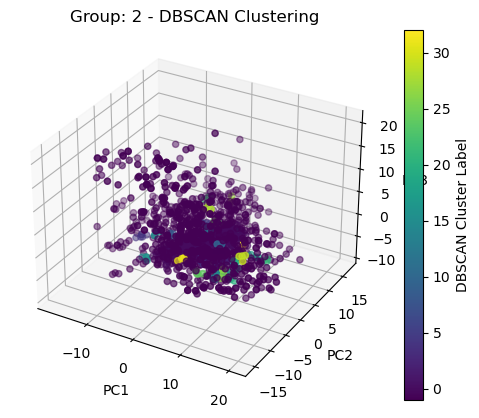

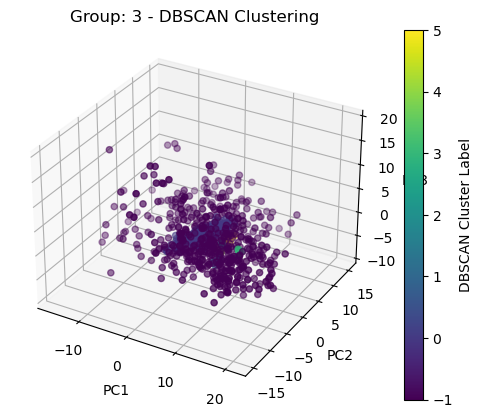

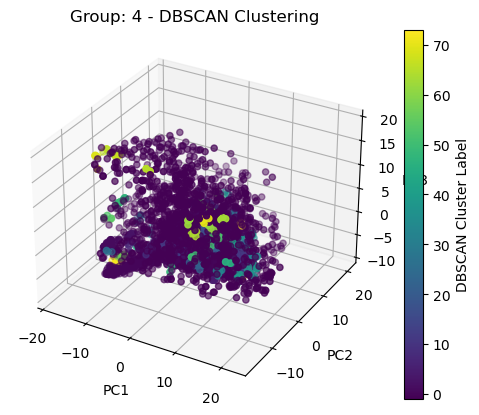

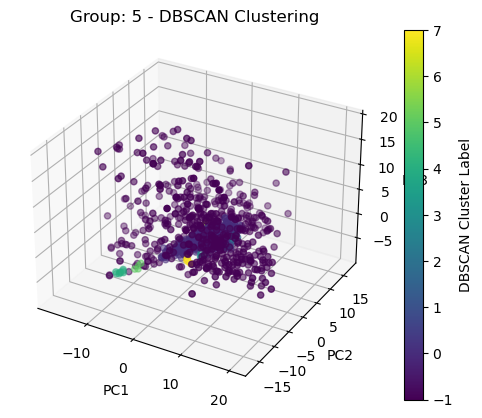

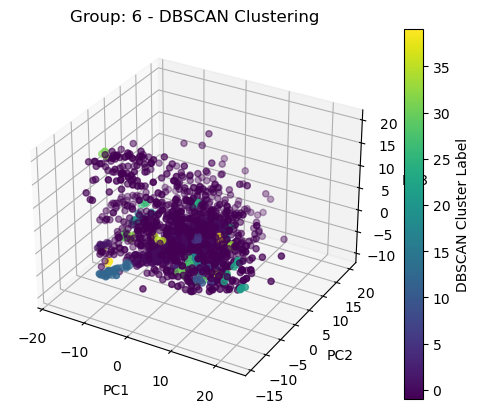

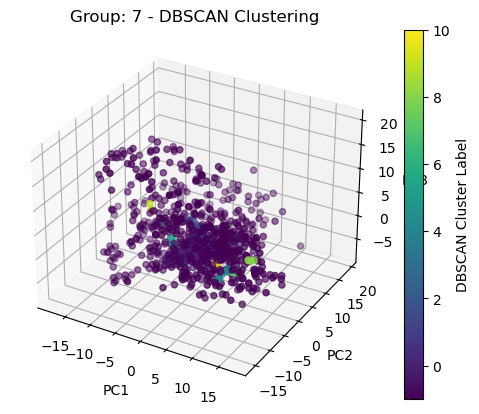

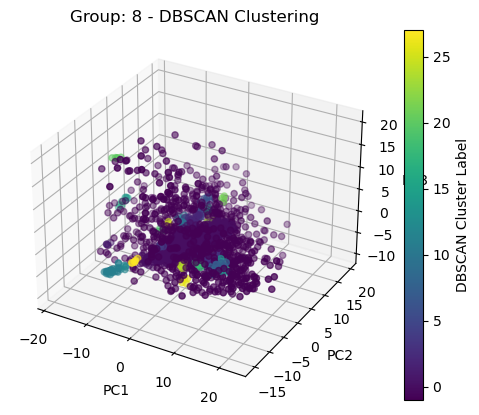

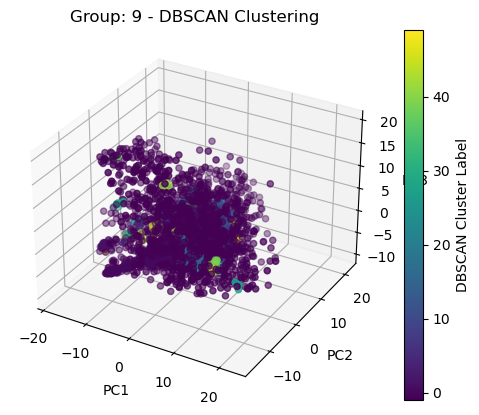

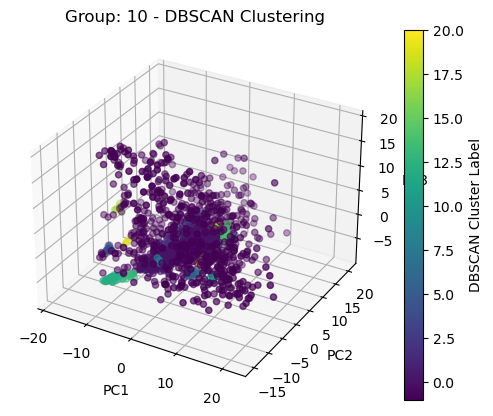

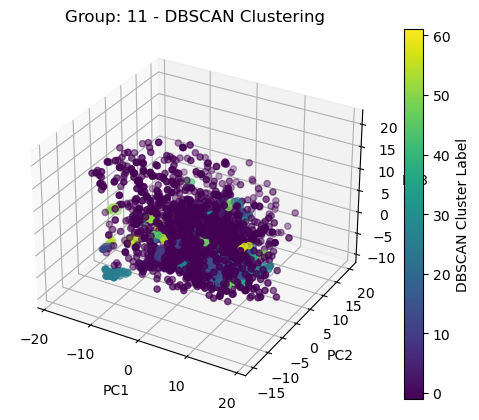

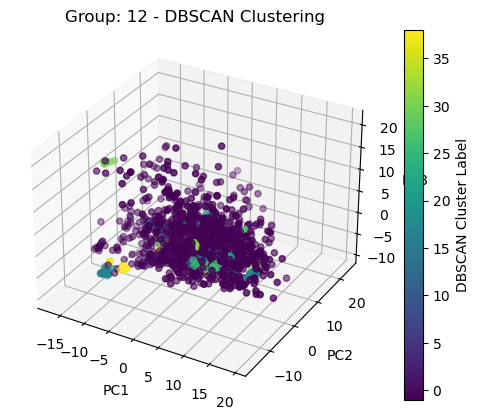

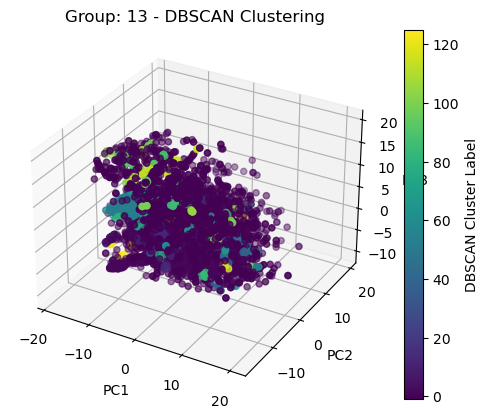

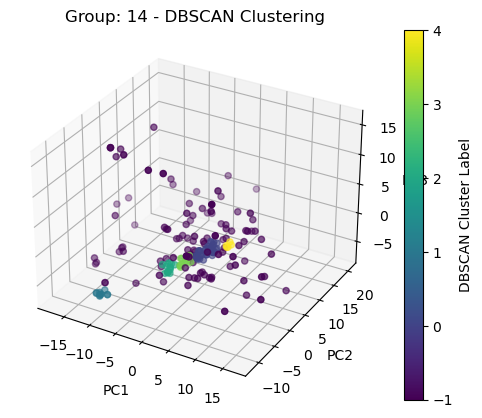

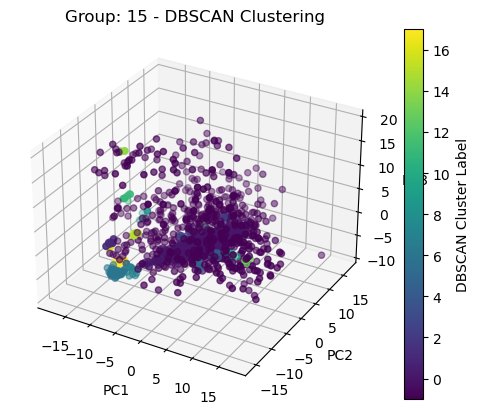

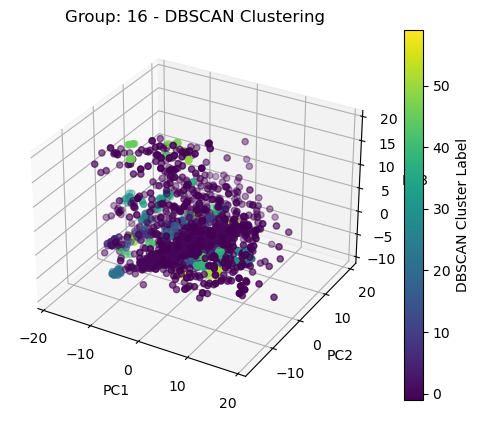

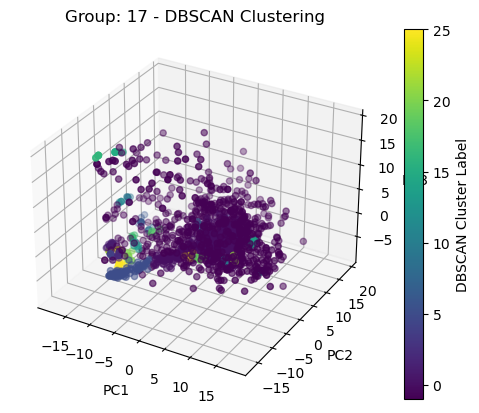

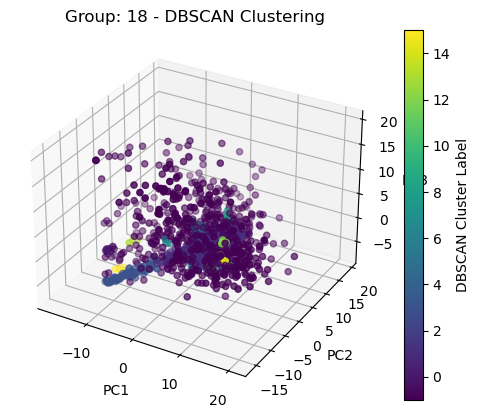

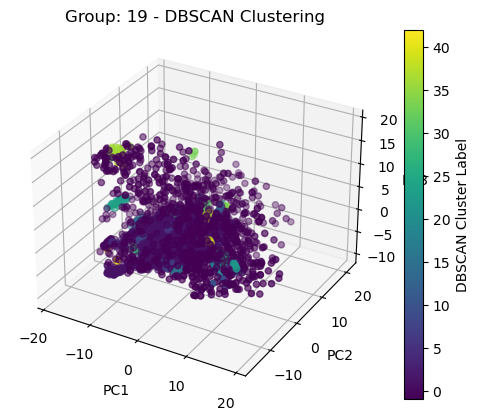

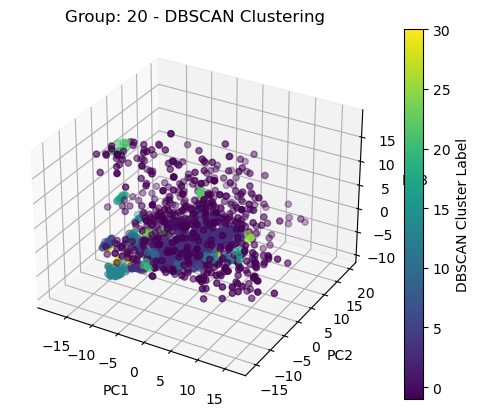

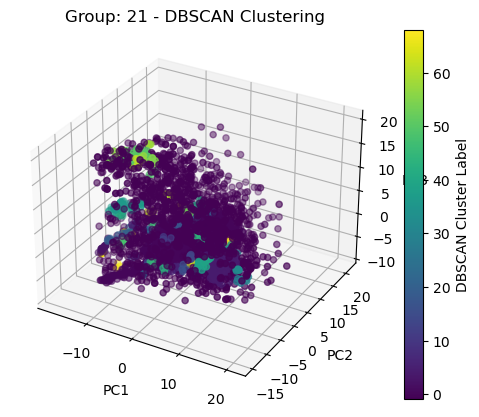

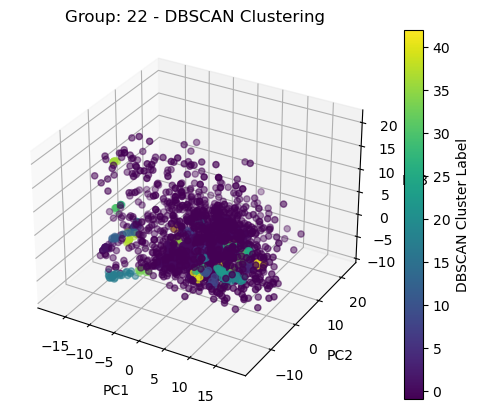

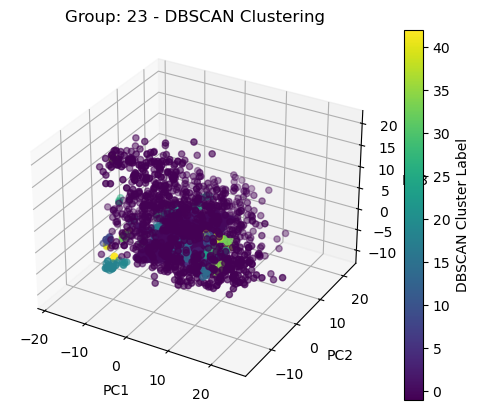

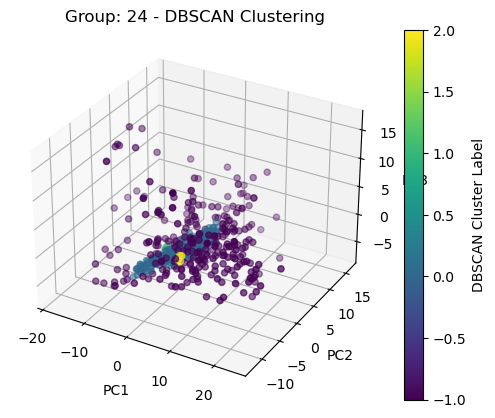

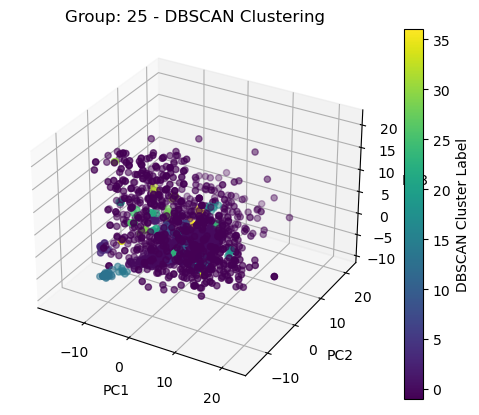

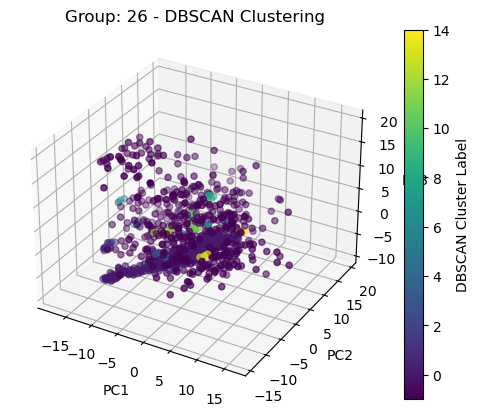

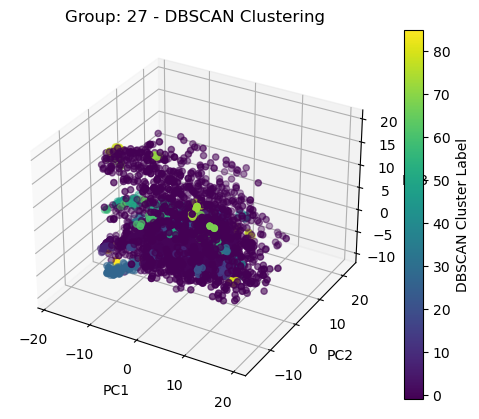

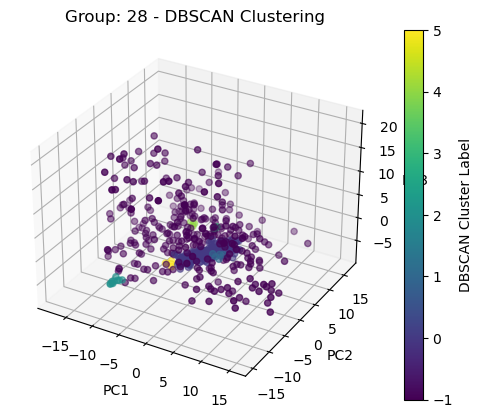

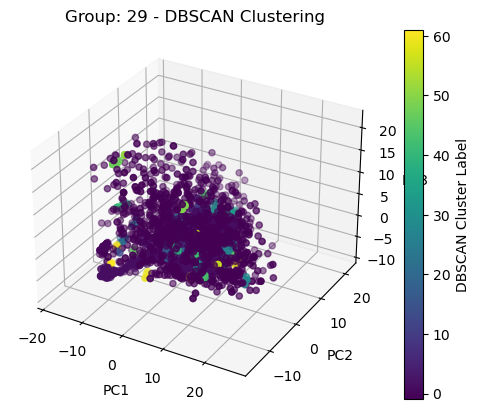

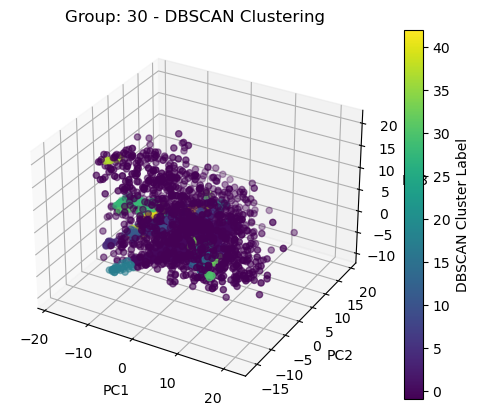

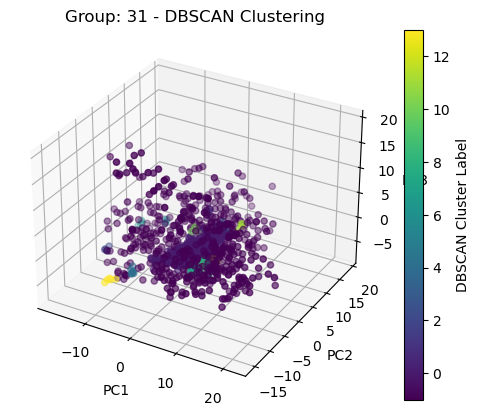

In [25]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


# Apply DBSCAN and plot for each group
def apply_dbscan_and_plot(df, eps=1, min_samples=4):
    # Get unique groups
    unique_groups = df['group'].unique()

    # Iterate over each group
    for group in unique_groups:
        # Filter the data for the current group
        group_data = df[df['group'] == group]

        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels

        # Plot 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(group_data['PC1'], group_data['PC2'], group_data['PC3'],
                             c=group_data['dbscan_label'], cmap='viridis', label=group)

        ax.set_title(f"Group: {group} - DBSCAN Clustering")
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

        # Add colorbar for the DBSCAN cluster labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('DBSCAN Cluster Label')

        # Show the plot
        plt.show()

# Assuming df_pca is already defined as in the previous step
apply_dbscan_and_plot(df_pca)

In [26]:
def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=5)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1', 'PC2', 'PC3']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]

        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1', 'PC2', 'PC3']].mean().values,
            'std': largest_cluster[['PC1', 'PC2', 'PC3']].std().values
        }

    return group_stats

group_stats = calculate_stats_for_largest_cluster(df_pca)

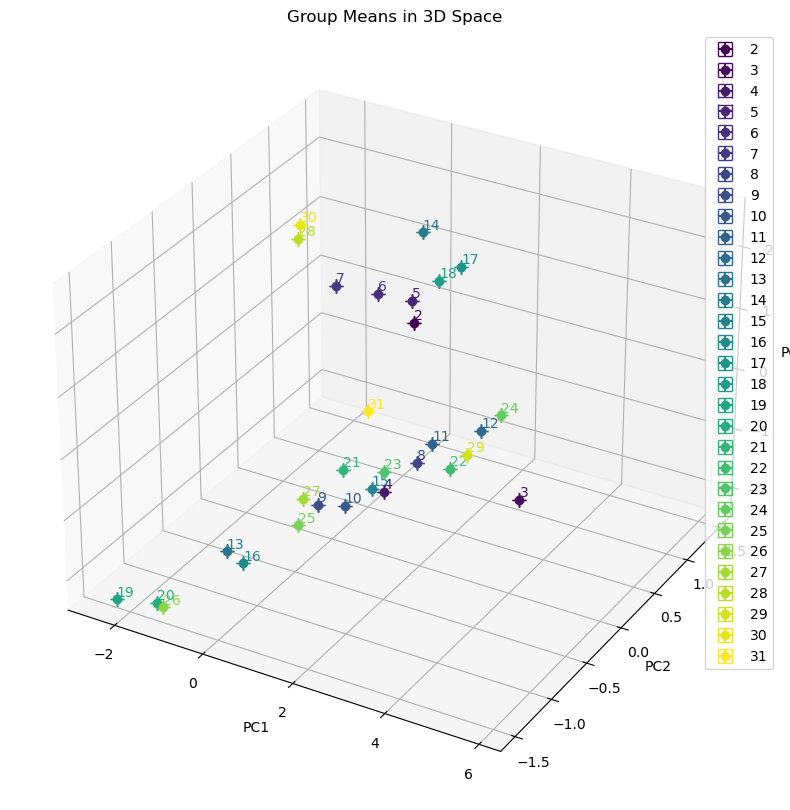

In [27]:


# file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_neighbors.pickle"

# # Read the pickle file
# with open(file_path, 'rb') as handle:
#     neighbors_dict = pickle.load(handle)

# Extract means and stds from group_stats
means = np.array([stats['mean'] for stats in group_stats.values()])
stds = np.array([stats['std'] for stats in group_stats.values()])
group_labels = list(group_stats.keys())

# Define a color map (you can adjust the colormap as needed)
colors = plt.cm.viridis(np.linspace(0, 1, len(group_labels)))

# Create a larger 3D plot (adjusting figsize)
fig = plt.figure(figsize=(12, 10))  # Increase the size (width, height)
ax = fig.add_subplot(111, projection='3d')

# Plot means with error bars, using different colors for each group
for i, label in enumerate(group_labels):
    ax.errorbar(means[i, 0], means[i, 1], means[i, 2], 
#                   xerr=stds[i, 0], yerr=stds[i, 1], zerr=stds[i, 2], 
                 xerr=0, yerr=0, zerr=0, 
                fmt='o', color=colors[i], label=label, capsize=5)

# Annotate each point with its group label
for i, label in enumerate(group_labels):
    ax.text(means[i, 0], means[i, 1], means[i, 2]+0.05, label, size=10, zorder=1, color=colors[i])

# Set labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Group Means in 3D Space')

# Show legend
ax.legend()

# Show the plot
plt.show()

creating data for timefusion transformer 

In [10]:

data_for_nn = []

for group in groups_splitted_normlized_ts:
    for drive in groups_splitted_normlized_ts[group]:
        drive['group'] = group

        data_for_nn.append(drive[['speed', 'acceleration_est_1', 'angular_acc','group']])

In [11]:
features = ['speed', 'acceleration_est_1', 'angular_acc']  # Columns to use as features
group_col = 'group'  # Column containing the labels

padded_drives, labels, lengths = process_drives(data_for_nn, features, group_col)

# Output shapes
print("Padded Drives Shape:", padded_drives.shape)  # (batch_size, max_timesteps, num_features)
print("Labels Shape:", labels.shape)  # (batch_size,)
print("Lengths Shape:", lengths.shape)  # (batch_size,)

import os
import torch

# Define the path to save the data
save_path = "/bigdata/users-home/dor/transpotation research/agg_data/nn_data/"

# Ensure the directory exists
os.makedirs(save_path, exist_ok=True)

# Processed data (assuming you've already run `process_drives`)
# padded_drives, labels, lengths = process_drives(data_for_nn, features, group_col)

# Save each tensor separately as .pt files
torch.save(padded_drives, os.path.join(save_path, "padded_drives.pt"))
torch.save(labels, os.path.join(save_path, "labels.pt"))
torch.save(lengths, os.path.join(save_path, "lengths.pt"))

print(f"Data saved successfully to {save_path}")



Padded Drives Shape: torch.Size([51703, 39, 3])
Labels Shape: torch.Size([51703])
Lengths Shape: torch.Size([51703])
Data saved successfully to /bigdata/users-home/dor/transpotation research/agg_data/nn_data/


In [20]:
create_map(dict_cor)
def create_map(dict_cor):
    # Create a base map
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Define colors for markers
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray', 'black', 'pink', 'yellow', 'cyan', 'magenta', 'teal', 'maroon', 'navy', 'olive', 'lavender', 'peach', 'turquoise', 'silver', 'gold']

    j= 0 
    # Iterate through the list of data frames and add markers to the map
    for group in dict_cor:
        lat, lon = dict_cor[group]
        color = colors[j % len(colors)]
        j+=1# Select color based on index



        folium.CircleMarker(location=[lat, lon], radius=10, color=color, fill=True, fill_color=color).add_to(m)
    return m
    
create_map(dict_cor)

In [30]:
dict_cor

{1: (32.088, 34.859),
 3: (32.002, 34.766),
 2: (32.185, 34.911),
 4: (32.081, 34.82),
 9: (32.09, 34.805),
 6: (32.101, 34.827),
 5: (32.084, 34.807),
 7: (32.019, 34.774),
 8: (32.087, 34.811)}

In [7]:
groups_ts = create_dict_groups2ts(dict_drives, all_drives)

In [9]:
splitted_ts_groups = create_feat_(groups_ts)

In [10]:
scaling_parameters = scaling(splitted_ts_groups)

In [11]:
dict_length = {}
for group in groups_ts:
    for se in groups_ts[group]:
        curr_len = len(se)
        se['group'] = group
        dict_length[curr_len] = dict_length.get(curr_len,[])
        dict_length[curr_len].append(se)
        
        
new_dict = {key: scaling_parameters[key]  for key in scaling_parameters if len(scaling_parameters[key])>30}
groups_splitted_normlized_ts = {}
for key in new_dict:
    lst = normalize_time_series(new_dict[key])
    for series in lst:
        group_num = int(series.iloc[0][['group']])
        groups_splitted_normlized_ts[group_num] = groups_splitted_normlized_ts.get(group_num,[])
        groups_splitted_normlized_ts[group_num].append(series)
        
dict_length = {}
for group in groups_splitted_normlized_ts:
    for series in groups_splitted_normlized_ts[group]:
        curr_len = len(series)
        if curr_len>=9:
            dict_length[curr_len] = dict_length.get(curr_len,[])
            dict_length[curr_len].append(series)
            
            

In [8]:
groups_ts

{1: [      longitude   latitude           orig_time  speed  direction  \
  1189  34.804675  32.090675 2018-03-29 07:21:30      0          0   
  1191  34.804676  32.090666 2018-03-29 07:21:33      0          0   
  1192  34.804666  32.090678 2018-03-29 07:21:37      0          0   
  1193  34.804655  32.090675 2018-03-29 07:21:41      0          0   
  1194  34.804651  32.090671 2018-03-29 07:21:45      0          0   
  ...         ...        ...                 ...    ...        ...   
  1313  34.858541  32.088315 2018-03-29 07:41:25      0          0   
  1314  34.858526  32.088343 2018-03-29 07:41:35      0          0   
  1315  34.858526  32.088335 2018-03-29 07:41:45      0          0   
  1316  34.858530  32.088343 2018-03-29 07:41:55      0          0   
  1317  34.858533  32.088343 2018-03-29 07:42:05      0          0   
  
        vehicle_state  road_speed  acceleration_est_1  angular_acc        date  \
  1189              2        50.0                0.00          0.0  2018

In [12]:

def calculate_stats_for_largest_cluster(df):
    group_stats = {}
    
    for group in df['group'].unique():
        group_data = df[df['group'] == group]
        dbscan = DBSCAN(eps=1, min_samples=5)
        dbscan_labels = dbscan.fit_predict(group_data[['PC1','PC2', 'PC3','PC4','PC5']])

        # Add DBSCAN labels to the DataFrame
        group_data['dbscan_label'] = dbscan_labels
        # Get the largest cluster
        largest_cluster_label = group_data['dbscan_label'].value_counts().idxmax()
        largest_cluster = group_data[group_data['dbscan_label'] == largest_cluster_label]

        # Calculate mean and std of features in the largest cluster
        group_stats[group] = {
            'mean': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].mean().values,
            'std': largest_cluster[['PC1','PC2', 'PC3','PC4','PC5']].std().values
        }

    return group_stats

In [19]:
neigh_dict

{1: 'Ramat Siv Industrial Zone', 3: 'Kiryat Mikha', 2: "Eli'ezer"}

In [31]:
import pandas as pd
import numpy as np
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def compute_cluster(neighbors_dict, dict_length, rand=100):
    """
    Computes clusters using MiniRocket transformation, PCA, and Spectral Clustering.
    Returns the labels for Spectral Clustering.
    """
    spectral_matrix = np.zeros((len(neigh_dict), len(neigh_dict)))
    
    def convert_dfs_to_arrays(df_list):
        """Convert list of DataFrames to numpy arrays."""
        arrays = []
        labels = []
        for df in df_list:
            arrays.append(df[['speed', 'acceleration_est_1', 'angular_acc']].values.T)  # Shape: (num_features, num_timesteps)
            labels.append(df.iloc[0]['group'])
        return np.stack(arrays, axis=0), labels

    t_labels = []  # True labels
    X_transformed_list = []  # List to store transformed arrays

    # Transform each DataFrame in dict_length using MiniRocket
    for key in dict_length:
        arrays, true_labels = convert_dfs_to_arrays(dict_length[key])
        t_labels += true_labels
        
        # Create and fit the MiniRocket transformer
        rocket = MiniRocketMultivariate(num_kernels=10000, random_state=int(rand))
        rocket.fit(arrays)

        # Transform the data and store it
        X_transformed = rocket.transform(arrays)
        X_transformed_list.append(X_transformed)

    # Concatenate all transformed arrays along the first axis
    X_transformed_all = np.concatenate(X_transformed_list, axis=0)

    # Apply PCA to reduce dimensions to 3 components
    pca = PCA(n_components=5)
    X_pca = pca.fit_transform(X_transformed_all)
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
    df_pca['group'] = t_labels

    # Calculate statistics for the largest cluster
    group_stats = calculate_stats_for_largest_cluster(df_pca)

    # Extract means for clustering
    X_means = np.array([stats['mean'] for stats in group_stats.values()])
    group_labels = list(group_stats.keys())

    def evaluate_spectral_clustering(X):
    
        silhouette_scores_spectral = []

        for k in range(2, len(neigh_dict)):
            # Spectral Clustering
            spectral = SpectralClustering(n_clusters=k, random_state=42)
            spectral_labels = spectral.fit_predict(X)

            # Check if there is more than one unique label
            if len(set(spectral_labels)) > 1:
                # Calculate silhouette score only if there is more than one unique cluster
                silhouette_scores_spectral.append(silhouette_score(X, spectral_labels))
            else:
                # Append a placeholder score (e.g., -1) if only one cluster is found
                silhouette_scores_spectral.append(-1)

        return silhouette_scores_spectral
    # Evaluate silhouette scores for Spectral Clustering
    silhouette_scores_spectral = evaluate_spectral_clustering(X_means)

    # Determine the best k for Spectral Clustering based on silhouette scores
    best_k_spectral = np.argmax(silhouette_scores_spectral) + 2

    # Apply Spectral Clustering with the best k
    spectral_labels = SpectralClustering(n_clusters=best_k_spectral, random_state=42).fit_predict(X_means)

    return spectral_labels

# Main execution loop
num_runs = 150
random_states = np.random.randint(0, 10000, size=num_runs)
spectral_matrix = np.zeros((len(neigh_dict), len(neigh_dict)))

for rand in random_states:
    spectral_labels = compute_cluster(neigh_dict, dict_length, rand)

    # Dictionary to count occurrences of clustering
    s_cluster_dict = {}

    # Count occurrences of clustering
    for i, group in enumerate(neigh_dict.keys()):
        s_cluster_dict[group] = spectral_labels[i]

    # Update matrix based on clustering results
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1


In [32]:
def highlight_cells(val):
    color = 'background-color: lightgreen' if val >= 0.9 else ''
    return color
rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[neigh_dict[i+1] for i in range(len(neigh_dict))], 
                         columns=[neigh_dict[i+1] for i in range(len(neigh_dict))])
df_spectral = df_spectral.style.applymap(highlight_cells)
df_spectral

3

In [ ]:
num_runs = 100
random_states = np.random.randint(0, 1000, size=num_runs)

for rand in random_states:
    kmeans_labels, gmm_labels, dbscan_labels, spectral_labels = compute_cluster(rand,neigh_dict,dict_length)

    # Dictionaries to count occurrences of clustering
    k_cluster_dict = {}
    g_cluster_dict = {}
    d_cluster_dict = {}
    s_cluster_dict = {}

    # Count occurrences of clustering for each method
    for i, group in enumerate(group_labels):
       
        g_cluster_dict[group] = gmm_labels[i]
       
        s_cluster_dict[group] = spectral_labels[i]



                
    for group in g_cluster_dict:
        for j in g_cluster_dict:
            if g_cluster_dict[group] == g_cluster_dict[j]:
                gmm_matrix[int(group - 1), int(j - 1)] += 1
                
                
    for group in s_cluster_dict:
        for j in s_cluster_dict:
            if s_cluster_dict[group] == s_cluster_dict[j]:
                spectral_matrix[int(group - 1), int(j - 1)] += 1


In [ ]:
def highlight_cells(val):
    color = 'background-color: lightgreen' if val > 0.9 else ''
    return color
rounded_gmm_matrix=np.round(gmm_matrix / num_runs, decimals=2)
df_gmm = pd.DataFrame(rounded_gmm_matrix, 
                         index=[translate_hebrew_to_english(neighbors_dict[i+1]) for i in range(len(neighbors_dict))], 
                         columns=[translate_hebrew_to_english(neighbors_dict[i+1]) for i in range(len(neighbors_dict))])
df_gmm = df_gmm.style.applymap(highlight_cells)
df_gmm

In [ ]:
rounded_spectral_matrix=np.round(spectral_matrix / num_runs, decimals=2)
df_spectral = pd.DataFrame(rounded_spectral_matrix, 
                         index=[translate_hebrew_to_english(neighbors_dict[i+1]) for i in range(len(neighbors_dict))], 
                         columns=[translate_hebrew_to_english(neighbors_dict[i+1]) for i in range(len(neighbors_dict))])
df_spectral = df_spectral.style.applymap(highlight_cells)
df_spectral

In [6]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = '/bigdata/users-home/dor/transpotation research/agg_data/all_cars_agg_drives_with_locations.csv'
filtered_agg_drives_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify
filtered_agg_drives_df.head()

VEHICLE_ID  START_LATITUDE  START_LONGITUDE  END_LATITUDE  END_LONGITUDE  \
0      623095          31.902           34.809        31.903         34.812   
1      623095          31.904           34.815        31.888         34.783   
2      623095          31.904           34.815        31.888         34.783   
3      623095          31.904           34.815        31.888         34.783   
4      623095          31.903           34.812        31.904         34.815   

   START_HOUR DAY_OF_WEEK  num_drives END_NEIGHBORHOOD START_NEIGHBORHOOD  
0           4      Friday          17      מעונות ויקס     מעונות וולפסון  
1          23    Saturday          17           רחובות       מעונות וילנר  
2          23      Sunday          17           רחובות       מעונות וילנר  
3          23   Wednesday          17           רחובות       מעונות וילנר  
4           4    Thursday          16     מעונות וילנר        מעונות ויקס

In [7]:
car_id = vehicle_ids[0]
curr_df=filtered_agg_drives_df[(filtered_agg_drives_df['VEHICLE_ID']==car_id) & (filtered_agg_drives_df['num_drives'] > 8 )]
curr_df

VEHICLE_ID  START_LATITUDE  START_LONGITUDE  END_LATITUDE  \
21676      485783          32.046           34.776        32.029   
21677      485783          31.812           34.656        31.818   
21678      485783          32.046           34.776        32.029   
21679      485783          32.046           34.776        32.029   
21680      485783          32.046           34.776        32.029   
...           ...             ...              ...           ...   
21819      485783          32.046           34.776        32.073   
21820      485783          32.074           34.799        32.046   
21821      485783          32.099           34.865        32.027   
21822      485783          32.099           34.865        32.028   
21823      485783          32.130           34.895        32.107   

       END_LONGITUDE  START_HOUR DAY_OF_WEEK  num_drives END_NEIGHBORHOOD  \
21676         34.794           5     Tuesday          37     אזור תעשיה א   
21677         34.666           1      Monday          34     קריית חלוצים   
21678         34.794           5      Monday          33     אזור תעשיה א   
21679         34.794           5   Wednesday          33     אזור תעשיה א   
21680         34.794           5    Thursday          32     אזור תעשיה א   
...              ...         ...         ...         ...              ...   
21819         34.797          16    Saturday           9        נחלת יצחק   
21820         34.776          18    Thursday           9        קרית שלום   
21821         34.894          14      Monday           9   קרית ביאליסטוק   
21822         34.895          14      Monday           9   קרית ביאליסטוק   
21823         34.890          13      Sunday           9            סגולה   

            START_NEIGHBORHOOD  
21676                קרית שלום  
21677             קריית איתנים  
21678                קרית שלום  
21679                קרית שלום  
21680                קרית שלום  
...                        ...  
21819                קרית שלום  
21820                נחלת יצחק  
21821  אזור התעשייה קריית אריה  
21822  אזור התעשייה קריית אריה  
21823           אזה"ת נוה נאמן  

[148 rows x 10 columns]

In [17]:
df = concated_data_with_feat(car_id)
df
# Convert all column names in the DataFrame to uppercase
df.columns = df.columns.str.upper()

# Extract the hour part from the "START_DRIVE" column and store it in a new column "START_HOUR"
df["START_HOUR"] = pd.to_datetime(df["START_DRIVE"]).dt.hour

# Extract the hour part from the "END_DRIVE" column and store it in a new column "END_HOUR"
df["END_HOUR"] = pd.to_datetime(df["END_DRIVE"]).dt.hour

# Extract the date (without time) from the "START_DRIVE" column and store it in a new column "DATE"
df["DATE"] = pd.to_datetime(df["START_DRIVE"]).dt.date

# Create a new column "DAY_OF_WEEK" that contains the day of the week (e.g., Monday, Tuesday)
df["DAY_OF_WEEK"] = df["DATE"].apply(lambda x: x.strftime("%A"))

# Set the index of the DataFrame to the values of the "DRIVE_ID" column
df.index = df['DRIVE_ID']

# Drop the "START_DRIVE" and "END_DRIVE" columns as they are no longer needed
df = df.drop(["START_DRIVE", "END_DRIVE"], axis=1)

# # Initialize the NEIGHBORHOOD column with None or empty values
# df['end_NEIGHBORHOOD'] = None
# df['start_NEIGHBORHOOD'] = None

# # # Iterate over rows with tqdm progress bar
# # for idx, row in tqdm(df.iterrows(), total=len(df)):
# #     df.at[idx, 'end_NEIGHBORHOOD'] = get_neighborhood_name(
# #         round(row['END_LATITUDE'], 4), 
# #         round(row['END_LONGITUDE'], 4)
# #     )
# #     df.at[idx, 'start_NEIGHBORHOOD'] = get_neighborhood_name(
# #         round(row['START_LATITUDE'], 4), 
# #         round(row['START_LONGITUDE'], 4)
# #     )
    
# # df_for_decision_tree = df[['end_NEIGHBORHOOD','start_NEIGHBORHOOD',
# #                            'DAY_OF_WEEK','DATE','VEHICLE_ID','DRIVE_ID',
# #                            'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE',
# #                            'END_LONGITUDE','END_HOUR','START_HOUR']]


grouped_df = df.copy()

# Round the "START_LATITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["START_LATITUDE"] = grouped_df["START_LATITUDE"].round(3)

# Round the "START_LONGITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["START_LONGITUDE"] = grouped_df["START_LONGITUDE"].round(3)

# Round the "END_LATITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["END_LATITUDE"] = grouped_df["END_LATITUDE"].round(3)

# Round the "END_LONGITUDE" column from `grouped_df` to 3 decimal places and assign it to `grouped_df`
grouped_df["END_LONGITUDE"] = grouped_df["END_LONGITUDE"].round(3)

# Group the DataFrame by the rounded "END_LATITUDE" and "END_LONGITUDE" columns
# Count the number of occurrences (drives) for each unique pair of latitude and longitude
# Reset the index and store the result in a new column named 'num_drives' 
grouped_df = grouped_df.groupby(['END_LATITUDE', 'END_LONGITUDE']).size().reset_index(name='num_drives')

most_driven_cor = grouped_df.sort_values(by='num_drives', ascending=False).iloc[0]
# Extract latitude and longitude from the selected row
latitude = most_driven_cor['END_LATITUDE']
longitude = most_driven_cor['END_LONGITUDE']

# Create a tuple of the most driven coordinates
home_cor = (latitude, longitude)

agg_drives_filt = grouped_df[(grouped_df['num_drives'] > 8)&((grouped_df['END_LATITUDE']!=latitude) & (grouped_df['END_LONGITUDE']!=longitude))].sort_values(by=[ 'num_drives'], ascending=[ False])

# agg_drives_filt = agg_drives_filt[(agg_drives_filt['START_LATITUDE'] != agg_drives_filt['END_LATITUDE'])&(agg_drives_filt['START_LONGITUDE'] != agg_drives_filt['END_LONGITUDE'])]
agg_drives_filt['NEIGHBORHOOD'] = agg_drives_filt.apply(lambda row: translate_hebrew_to_english(get_neighborhood_name(row['END_LATITUDE'], row['END_LONGITUDE'])), axis=1)
agg_drives_filt

END_LATITUDE  END_LONGITUDE  num_drives        NEIGHBORHOOD
127         31.827         34.654         494       Kiryat Ethnic
601         32.073         34.797         384       Nahalat Isaac
410         32.029         34.794         354   Industrial zone a
612         32.074         34.799         238       Nahalat Isaac
894         32.130         34.895         229     UN Neve Ne'eman
...            ...            ...         ...                 ...
1100        32.321         34.867           9       Kiryat Nordau
419         32.031         34.796           9        Area Gardens
822         32.108         34.957           9        Rosh Ha'ayin
677         32.083         34.803           9  The stock exchange
902         32.132         34.901           9       Neve faithful

[115 rows x 4 columns]

In [18]:

def tag_drives(agg_drives,driver=1):
    drives_df = agg_drives.copy()
    drives_df['driver'] = 0
    driver_dict = {}
#     agg_drives.at[3263176, 'driver'] = 0
    for i, row in drives_df.iterrows():
#         agg_drives.at[i, 'driver'] = int(0)
        if  i == drives_df.index[0]:
            drives_df.at[i, 'driver'] = driver
            driver_dict[i] = row
        else:
            for j in driver_dict:
                if (
                    row['NEIGHBORHOOD'] == driver_dict[j]['NEIGHBORHOOD']):
#                     and row['START_HOUR'] == driver_dict[j]['START_HOUR']):
#                     and row['END_LATITUDE'] == driver_dict[j]['END_LATITUDE']
#                     and row['END_LONGITUDE'] == driver_dict[j]['END_LONGITUDE'] ):

                        drives_df.at[i, 'driver'] = driver
                        break  # Exit the loop once a match is found
    return drives_df[drives_df['driver']==1] , drives_df[drives_df['driver']==0]

def get_drives(df, drives_group, with_returns=True):   
    # List to store indices of matching drives
    matching_drives = []

    # Iterate over each row in the dataframe and drives_group
    for index_df, row_df in df.iterrows():
        for index_dg, row_dg in drives_group.iterrows():
            # Check if the end coordinates of the current drive in df match
            # the end coordinates of the current drive in drives_group
            if (round(row_df['END_LATITUDE'], 3) == row_dg['END_LATITUDE'] and
                round(row_df['END_LONGITUDE'], 3) == row_dg['END_LONGITUDE']):
                # If match found, append index of the drive in df to matching_drives
                matching_drives.append(index_df)
                # Break the inner loop as we've found a match
                break

    if with_returns:
        # Iterate over the filtered dataframe (df) based on matching indices
        for index_df, row_df in df[df.index.isin(matching_drives)].iterrows():
            # Iterate again over the entire dataframe to find drives starting where
            # the matching drives end and on the same date
            for index, row in df.iterrows():
                if (round(row_df['END_LATITUDE'], 3) == round(row['START_LATITUDE'], 3) and
                    round(row_df['END_LONGITUDE'], 3) == round(row['START_LONGITUDE'], 3) and
                    row_df['DATE'] == row['DATE']):
                    # If conditions match, append index of the drive in df to following_drives
                    matching_drives.append(index)
                    break
    
    return matching_drives

# Initialize three dictionaries to store results:
# - dict_drives: stores DataFrames of filtered drives for each group
# - dict_sum: stores the count of drives for each group
# - dict_cor: stores the coordinates (latitude, longitude) for the first drive in each group
dict_drives = {}
dict_sum = {}
dict_cor = {}

# Make a copy of the filtered drives DataFrame (agg_drives_filt) to preserve the original data
agg_drives2 = agg_drives_filt.copy()

# Initialize a counter `i` to label different driver groups
i = 1

# Loop until there is only one drive left in the agg_drives2 DataFrame
while len(agg_drives2) > 1:
    
    # Tag the drives in the remaining DataFrame (agg_drives2), separating the current group of drives
    # `tag_drives_group`: the drives tagged with the current driver (1)
    # `agg_drives2`: the remaining drives not yet tagged (driver 0)
    tag_drives_group, agg_drives2 = tag_drives(agg_drives2)
    
    # Get a list of drive indices from the original DataFrame (df) that match the coordinates of the tagged group
    driver1_lst = get_drives(df, tag_drives_group)
    
    # Create a new DataFrame (driver1_df) that contains only the matching drives from the cleaned DataFrame
    # - Filter columns to keep only the first 15 columns from `columns_og` along with 'END_LATITUDE' and 'END_LONGITUDE'
    driver1_df = df[df.index.isin(driver1_lst)][ ['END_LATITUDE', 'END_LONGITUDE']]
    
    # Calculate the total number of drives (rows) in this group
    sum_drives = len(driver1_df)
    
    # If the group contains any drives, proceed to record data
    if sum_drives > 0:
        
        # Store the coordinates (latitude, longitude) of the first drive in the group
        dict_cor[i] = (float(tag_drives_group.head(1)['END_LATITUDE']), float(tag_drives_group.head(1)['END_LONGITUDE']))
        
        # Store the count of drives in the current group
        dict_sum[i] = sum_drives
        
        # Store the DataFrame of drives for the current group
        dict_drives[i] = driver1_df
    
    # Increment the counter `i` for the next group
    i += 1

# Sort the `dict_sum` dictionary by the number of drives in descending order
# - This step ensures that the groups with the largest number of drives come first
dict_sum = {k: v for k, v in sorted(dict_sum.items(), key=lambda item: item[1], reverse=True)}

# Reorder `dict_cor` based on the sorted keys of `dict_sum`, so that the coordinates are consistent with the sorted groups
dict_cor = {k: dict_cor[k] for k in dict_sum.keys()}

# Reorder `dict_drives` similarly, to match the sorted group order
dict_drives = {k: dict_drives[k] for k in dict_sum.keys()}

# Print the final `dict_sum`, which contains the number of drives for each group
print(dict_sum)


{2: 1175, 6: 602, 1: 580, 3: 523, 4: 485, 9: 358, 5: 319, 7: 300, 10: 233, 8: 221, 12: 175, 11: 168, 13: 118, 16: 118, 24: 99, 22: 95, 14: 90, 19: 88, 17: 84, 15: 83, 23: 64, 20: 61, 18: 57, 21: 54, 34: 48, 26: 41, 28: 40, 25: 37, 29: 35, 27: 34, 45: 34, 49: 32, 30: 31, 33: 31, 35: 27, 37: 27, 42: 27, 32: 25, 36: 24, 43: 22, 39: 21, 40: 21, 41: 21, 31: 20, 38: 20, 44: 19, 53: 18, 48: 17, 46: 16, 47: 16, 51: 14, 50: 13, 52: 12}


In [19]:
keys_to_delete = [key for key, value in dict_sum.items() if value < 60]
for key in keys_to_delete:
    del dict_sum[key]
    del dict_drives[key]
    del dict_cor[key]

print(dict_sum)

{2: 1175, 6: 602, 1: 580, 3: 523, 4: 485, 9: 358, 5: 319, 7: 300, 10: 233, 8: 221, 12: 175, 11: 168, 13: 118, 16: 118, 24: 99, 22: 95, 14: 90, 19: 88, 17: 84, 15: 83, 23: 64, 20: 61}


In [20]:
def remap_keys(dicts):
    # Find the minimum key in all dictionaries
    min_key = min(min(d) for d in dicts)
    # Create a mapping from old keys to new keys
    key_mapping = {old_key: idx + min_key for idx, old_key in enumerate(sorted(set.union(*map(set, dicts))))}
    # Remap keys in all dictionaries
    remapped_dicts = [{key_mapping[key]: value for key, value in d.items()} for d in dicts]
    return tuple(remapped_dicts)

In [21]:
lst = remap_keys([dict_sum, dict_drives, dict_cor])
dict_sum =lst[0]
dict_drives = lst[1]
dict_cor = lst[2]

In [22]:
dict_sum = {k: v for k, v in sorted(dict_sum.items(), key=lambda item: item[1], reverse=True)}

dict_cor = {k: dict_cor[k] for k in dict_sum.keys()}
dict_drives = {k: dict_drives[k] for k in dict_sum.keys()}

In [23]:
neigh_dict = {}
for group in dict_cor:
    neigh_dict[group] = get_neighborhood_name(dict_cor[group][0], dict_cor[group][1])
    print("Neighborhood:", neigh_dict[group],group)

Neighborhood: נחלת יצחק 2
Neighborhood: Neighborhood not found 6
Neighborhood: קריית איתנים 1
Neighborhood: אזור תעשיה א 3
Neighborhood: אזה"ת נוה נאמן 4
Neighborhood: גני אזור 9
Neighborhood: אזור תעשייה ג 5
Neighborhood: אזור התעשייה קריית אריה 7
Neighborhood: סגולה 10
Neighborhood: קריית ראשון 8
Neighborhood: קרית ביאליסטוק 12
Neighborhood: נווה סביון 11
Neighborhood: לוד 13
Neighborhood: אוניברסיטת ת"א 16
Neighborhood: אזור תעשייה ב 22
Neighborhood: קריית נורדאו 20
Neighborhood: גבעת טל 14
Neighborhood: كفر قاسم‎ 18
Neighborhood: אורות 17
Neighborhood: מנשייה‎ 15
Neighborhood: מועצה אזורית עמק חפר 21
Neighborhood: לב תל-אביב 19


In [5]:
import requests

# URL for the Israel OSM extract (PBF format)
url = "https://download.geofabrik.de/asia/israel-and-palestine-latest.osm.pbf"
file_path = "israel-latest.osm.pbf"

# Download the file
response = requests.get(url, stream=True)
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print(f"Downloaded {file_path}")


Downloaded israel-latest.osm.pbf


In [2]:


# Path to the Israel OSM data file
file_path = "israel-latest.osm.pbf"

def download_israel_osm_data():
    """Download Israel OSM data if not already present."""
    url = "https://download.geofabrik.de/asia/israel-and-palestine-latest.osm.pbf"
    if not os.path.exists(file_path):
        print("Downloading Israel OSM data...")
        response = requests.get(url, stream=True)
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"Downloaded OSM data to {file_path}")
    else:
        print("OSM data file already exists.")

def get_neighborhood_name(lat, lon):
    """Returns the neighborhood name given latitude and longitude."""
    # Download OSM data if necessary
    download_israel_osm_data()
    
    # Load the data
    osm = OSM(file_path)
    # Filter for neighborhoods
    gdf = osm.get_data_by_custom_criteria(
        custom_filter={"place": ["neighbourhood"]},
        osm_keys_to_keep=["name"]
    )
    
    # Convert latitude and longitude to a Shapely Point
    point = Point(lon, lat)
    
    # Find the neighborhood that contains the point
    neighborhood = gdf[gdf.contains(point)]
    
    if not neighborhood.empty:
        return neighborhood  # Adjust column name if different
    else:
        return "Neighborhood not found"

# Example usage
latitude = 32.0853  # Latitude for Tel Aviv
longitude = 34.7818  # Longitude for Tel Aviv
neighborhood = get_neighborhood_name(latitude, longitude)
print(f"Neighborhood: {neighborhood}")


OSM data file already exists.
Neighborhood:                                                   tags  version  lon visible  \
650  {"alt_name:en":"The New North - HaMedina squar...        9  NaN     NaN   

     lat           id   timestamp  changeset          place  \
650  NaN  13398127216  1697998986        0.0  neighbourhood   

                                              geometry  osm_type  
650  POLYGON ((34.79530 32.09100, 34.79536 32.09076...  relation  


In [22]:
neighborhood['tags'][650]

'{"alt_name:en":"The New North - HaMedina square","name":"\\u05D4\\u05E6\\u05E4\\u05D5\\u05DF \\u05D4\\u05D7\\u05D3\\u05E9 - \\u05E1\\u05D1\\u05D9\\u05D1\\u05EA \\u05DB\\u05DB\\u05E8 \\u05D4\\u05DE\\u05D3\\u05D9\\u05E0\\u05D4","name:ar":"\\u0627\\u0644\\u0634\\u0645\\u0627\\u0644 \\u0627\\u0644\\u062C\\u062F\\u064A\\u062F - \\u0645\\u064A\\u062F\\u0627\\u0646 \\u0647\\u0645\\u062F\\u064A\\u0646\\u0629","name:en":"The New North - Kikar HaMedina","name:fr":"Le Nouveau Nord - Kikar HaMedina","name:he":"\\u05D4\\u05E6\\u05E4\\u05D5\\u05DF \\u05D4\\u05D7\\u05D3\\u05E9 - \\u05E1\\u05D1\\u05D9\\u05D1\\u05EA \\u05DB\\u05DB\\u05E8 \\u05D4\\u05DE\\u05D3\\u05D9\\u05E0\\u05D4","name:ru":"\\u041D\\u043E\\u0432\\u044B\\u0439 \\u0421\\u0435\\u0432\\u0435\\u0440 - \\u041A\\u0438\\u043A\\u0430\\u0440 \\u0425\\u0430\\u041C\\u0435\\u0434\\u0438\\u043D\\u0430","source":"Tel Aviv municipality","type":"multipolygon"}'

In [9]:
import os
import requests
from shapely.geometry import Point
from pyrosm import OSM

file_path = "israel-latest.osm.pbf"

def download_israel_osm_data():
    url = "https://download.geofabrik.de/asia/israel-and-palestine-latest.osm.pbf"
    if not os.path.exists(file_path):
        response = requests.get(url, stream=True)
        with open(file_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)

def prepare_neighborhood_index():
    # Load OSM data
    osm = OSM(file_path)
    gdf = osm.get_data_by_custom_criteria(
        custom_filter={"place": ["neighbourhood"]},
        osm_keys_to_keep=["name"]
    )
    # Build a spatial index for neighborhoods
    gdf = gdf.to_crs("EPSG:4326")  # Ensure coordinates are in lat/lon
    return gdf, gdf.sindex

def get_neighborhood_name(lat, lon, gdf, spatial_index):
    # Create a Point object
    point = Point(lon, lat)
    
    # Use spatial index to get possible matches
    possible_matches_index = list(spatial_index.intersection(point.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    
    # Check each candidate polygon for containment
    for idx, neighborhood in possible_matches.iterrows():
        if neighborhood['geometry'].contains(point):
            dict_obj = json.loads(neighborhood['tags'])
            return dict_obj['name:en']
    
    return "Neighborhood not found"

# Download data if necessary and prepare the spatial index
download_israel_osm_data()
gdf, spatial_index = prepare_neighborhood_index()

# Example usage
latitude = 32.0851  # Tel Aviv latitude
longitude = 34.7812  # Tel Aviv longitude
neighborhood = get_neighborhood_name(latitude, longitude, gdf, spatial_index)
print(f"Neighborhood: {neighborhood}")


Neighborhood: Neighborhood not found


In [10]:
dict_obj = json.loads(neighborhood['tags'])

TypeError: string indices must be integers

In [ ]:
dict_obj['name:en']

In [15]:
from opencage.geocoder import OpenCageGeocode

def get_geographic_info_opencage(latitude, longitude):
    key = 'ede7e3aada8147188172eef6bc3dd326'  # Replace with your OpenCage API key
    geocoder = OpenCageGeocode(key)
    result = geocoder.reverse_geocode(latitude, longitude, no_annotations='1', language='en')
    
    if result:
        location = result[0]
        components = location['components']
        return {
            "neighborhood": components.get('neighbourhood') or components.get('suburb'),
            "suburb": components.get('suburb'),
            "city": components.get('city') or components.get('town'),
            "state": components.get('state'),
            "country": components.get('country'),
            "postal_code": components.get('postcode')
        }
    else:
        return {"error": "Location not found"}

# Example usage
latitude = 40.712776
longitude = -74.005974
print(get_geographic_info_opencage(latitude, longitude))



{'neighborhood': 'Civic Center', 'suburb': None, 'city': 'New York', 'state': 'New York', 'country': 'United States', 'postal_code': '10000'}


In [13]:
%pip install opencage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 582.4 kB/s eta 0:00:00 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 2.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.8/320.8 kB 6.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.1
    Uninstalling tqdm-4.64.1:
      Successfully uninstalled tqdm-4.64.1
  Attempting uninstall: certifi
    Found existing installation: certifi 2022.12.7
    Uninstalling certifi-2022.12.7:
      Successfully uninstalled certifi-2022.12.7
  Attempting uninstall: yarl
    Found existing installation: yarl 1.9.4
    Uninstalling yarl-1.9.4:
      Successfully uninstalled yarl-1.9.4
  Attemptin